In [1]:

import numpy as np 
import pandas as pd 

# Input data files are available in the read-only "../input/" directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv


# **Import library**

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
from sklearn.metrics import roc_auc_score , accuracy_score , confusion_matrix , f1_score
from sklearn.multiclass import OneVsRestClassifier
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# **Read dataset**

In [41]:
traindf = pd.read_csv("../input/jigsaw-toxic-comment-classification-challenge/train.csv")
testdf = pd.read_csv("../input/jigsaw-toxic-comment-classification-challenge/test.csv")

In [42]:
traindf.head(2)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0


In [43]:
traindf[traindf['toxic']==1].head(2)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0


# **Data Preprocessing**

In [44]:
cols_target = []
i = 0
for col in traindf.columns:
    if i == 0 or i == 1:
        i += 1
        continue
    cols_target.append(col)

In [45]:
cols_target

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [46]:
# check missing values in numeric columns
traindf.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [47]:
len(traindf['toxic'].drop_duplicates())

2

In [48]:
traindf[traindf['comment_text'].isnull()]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate


In [49]:
testdf[testdf['comment_text'].isnull()]

,id,comment_text


In [50]:
print('Total rows in test is {}'.format(len(testdf)))
print('Total rows in train is {}'.format(len(traindf)))
print(traindf[cols_target].sum())

Total rows in test is 153164
Total rows in train is 159571
toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


In [51]:
data = traindf[cols_target]

<AxesSubplot:title={'center':'Correlation of features & targets'}>

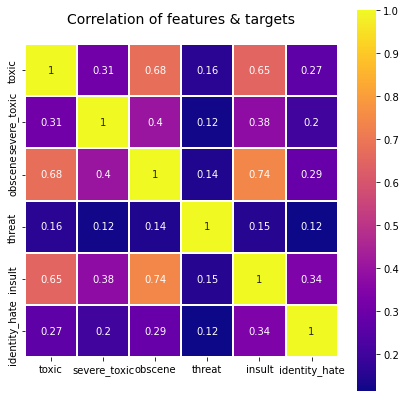

In [52]:
colormap = plt.cm.plasma
plt.figure(figsize=(7,7))
plt.title('Correlation of features & targets',y=1.05,size=14)
sns.heatmap(data.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,cmap=colormap,
           linecolor='white',annot=True)

# **Function to Clean the data**

In [1]:
def cleanData(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [54]:
traindf['comment_text'] = traindf['comment_text'].apply(lambda x:cleanData(x))
testdf['comment_text'] = testdf['comment_text'].apply(lambda x:cleanData(x))

# **Removing of stopWords**

In [55]:
traindf['comment_text'].head(5)

0    explanation why the edits made under my userna...
1    d aww he matches this background colour i am s...
2    hey man i am really not trying to edit war it ...
3    more i cannot make any real suggestions on imp...
4    you sir are my hero any chance you remember wh...
Name: comment_text, dtype: object

In [56]:
eng_stopwords = set(stopwords.words("english"))

In [57]:
traindf['comment_text'] = traindf['comment_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (eng_stopwords)]))
testdf['comment_text'] = testdf['comment_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (eng_stopwords)]))

In [58]:
traindf['comment_text'].head(5)

0    explanation edits made username hardcore metal...
1    aww matches background colour seemingly stuck ...
2    hey man really trying edit war guy constantly ...
3    cannot make real suggestions improvement wonde...
4                        sir hero chance remember page
Name: comment_text, dtype: object

# **Applying Lemmatization or Stemming**

In [59]:
stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()

In [60]:
# stemming and lemmatizing
# adapted from the kernal 

def stem_word(text):
    txt = " ".join([stemmer.stem(w) for w in text.split()])
    return text

def lemmatize_word(text):
    txt = " ".join([wordnet_lemmatizer.lemmatize(w) for w in text.split()])

In [61]:
SL = -1

In [62]:
if(SL == 1):
    traindf['comment_text'] = traindf['comment_text'].map(lambda x: stem_word(x))
    testdf['comment_text'] = testdf['comment_text'].map(lambda x: stem_word(x))
else:
    traindf['comment_text'] = traindf['comment_text'].map(lambda x: lemmatize_word(x))
    testdf['comment_text'] = testdf['comment_text'].map(lambda x: lemmatize_word(x))

In [63]:
traindf['comment_text']

0         explanation edits made username hardcore metal...
1         aww matches background colour seemingly stuck ...
2         hey man really trying edit war guy constantly ...
3         cannot make real suggestions improvement wonde...
4                             sir hero chance remember page
                                ...                        
159566    second time asking view completely contradicts...
159567    ashamed horrible thing put talk page 128 61 19 93
159568    spitzer umm theres actual article prostitution...
159569    looks like actually put speedy first version d...
159570    really think understand came idea bad right aw...
Name: comment_text, Length: 159571, dtype: object

In [64]:
X = traindf.comment_text
Y = traindf.drop(['id', 'comment_text'], axis = 1)

In [65]:
print(X.shape, Y.shape)

(159571,) (159571, 6)


In [66]:
X_train,X_test, y_train,y_test= train_test_split(X,Y,test_size=0.2, random_state=1)

In [67]:
X_train.head(2)

150865    indicated blocked editor comments might allowe...
59427     even userboxes others page one userbox meaning...
Name: comment_text, dtype: object

In [68]:
y_train.head(2)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
150865,0,0,0,0,0,0
59427,0,0,0,0,0,0


In [71]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(127656,)
(127656, 6)
(31915,)
(31915, 6)


# **Term Frequency Inverse Document Frequency Vectorizer**

In [73]:
word_vectorizer = TfidfVectorizer(
    strip_accents='unicode',     
    analyzer='word',            
    token_pattern=r'\w{1,}',    
    ngram_range=(1, 3),
    sublinear_tf=True)

word_vectorizer.fit(X_train)    
train_word_features = word_vectorizer.transform(X_train)
test_features = word_vectorizer.transform(X_test)

In [74]:
print(test_features)

  (0, 5866984)	0.2942800064840123
  (0, 5856845)	0.105274443722764
  (0, 5797987)	0.29059846088813784
  (0, 4592543)	0.41547809852940654
  (0, 4102255)	0.2961286714118136
  (0, 3594853)	0.17113893165523678
  (0, 3391164)	0.4308412180754633
  (0, 3390919)	0.29532531732717643
  (0, 2509175)	0.17223403929975795
  (0, 2223881)	0.39251154326933785
  (0, 2020463)	0.26775969703058516
  (1, 6045481)	0.034213979491999655
  (1, 6037090)	0.050488499175941864
  (1, 6034497)	0.02323359696247996
  (1, 6023221)	0.057302224729307336
  (1, 6023220)	0.057302224729307336
  (1, 6023217)	0.05091616566543752
  (1, 6017497)	0.02498073804781958
  (1, 5979133)	0.051902474983162444
  (1, 5974701)	0.05479148407884661
  (1, 5974566)	0.03605969786140249
  (1, 5970602)	0.03668504231622314
  (1, 5970385)	0.048229868351854825
  (1, 5970042)	0.037960408319683406
  (1, 5958551)	0.03707023129929523
  :	:
  (31913, 4352782)	0.25772635245653225
  (31913, 2207541)	0.39128265225143405
  (31913, 94221)	0.5273949058922298
  (

In [80]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

# **Model Validation on train data set**

In [81]:
losses = []
auc = []

for class_name in cols_target:
    #call the labels one column at a time so we can run the classifier on them
    train_target = y_train[class_name]
    test_target = y_test[class_name]
    classifier = LogisticRegression(solver='sag', C=10)

    cv_loss = np.mean(cross_val_score(classifier, train_word_features, train_target, cv=5, scoring='neg_log_loss'))
    losses.append(cv_loss)
    print('CV Log_loss score for class {} is {}'.format(class_name, cv_loss))

    cv_score = np.mean(cross_val_score(classifier, train_word_features, train_target, cv=5, scoring='accuracy'))
    print('CV Accuracy score for class {} is {}'.format(class_name, cv_score))
    
    classifier.fit(train_word_features, train_target)
    y_pred = classifier.predict(test_features)
    y_pred_prob = classifier.predict_proba(test_features)[:, 1]
    auc_score = metrics.roc_auc_score(test_target, y_pred_prob)
    auc.append(auc_score)
    print("CV ROC_AUC score {}\n".format(auc_score))
    
    print(confusion_matrix(test_target, y_pred))
    print(classification_report(test_target, y_pred))

print('Total average CV Log_loss score is {}'.format(np.mean(losses)))
print('Total average CV ROC_AUC score is {}'.format(np.mean(auc)))

CV Log_loss score for class toxic is -0.12863461870255985
CV Accuracy score for class toxic is 0.951126456946513
CV ROC_AUC score 0.9715990354128325

[[28466   346]
 [  923  2180]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     28812
           1       0.86      0.70      0.77      3103

    accuracy                           0.96     31915
   macro avg       0.92      0.85      0.88     31915
weighted avg       0.96      0.96      0.96     31915

CV Log_loss score for class severe_toxic is -0.030711030483080937
CV Accuracy score for class severe_toxic is 0.9902002243152864
CV ROC_AUC score 0.9856224961987531

[[31358   254]
 [  159   144]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     31612
           1       0.36      0.48      0.41       303

    accuracy                           0.99     31915
   macro avg       0.68      0.73      0.70     31915
weighted avg       0.99

# **Test Prediction**

In [86]:
def make_test_predictions(df,classifier):
    df.comment_text = df.comment_text.apply(cleanData)
    X_test = df.comment_text
    X_test_transformed = word_vectorizer.transform(X_test)
    y_test_pred = classifier.predict_proba(X_test_transformed)
    result =  sum(y_test_pred[0])
    if result >=1 :
       return("Toxic Comment")
    else :
       return ("NonToxic Comment")

In [95]:
log_reg = LogisticRegression(C = 10, penalty='l2', solver = 'liblinear', random_state=45)
classifier = OneVsRestClassifier(log_reg)
classifier.fit(train_word_features, y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=10, random_state=45,
                                                 solver='liblinear'))

In [96]:
comment_text = "I don't think so"
comment ={'id':[565],'comment_text':[comment_text]}
comment = pd.DataFrame(comment)
result = make_test_predictions(comment,classifier)
print(result)

NonToxic Comment
